### 3.1 Evaluation Criterion

#### AIC (akaike information criterion)

$ AIC = -2ln(L) + 2k$

#### BIC (bayesian information criterion)

$ BIC = -2ln(L) + ln(n)*k$

### 3.2 Mathematical formulation of ARIMA models

[AR, MA and ARMA models](http://www.math.unm.edu/~ghuerta/tseries/week4_1.pdf)

[The Identification of ARIMA Models](https://www.le.ac.uk/users/dsgp1/COURSES/THIRDMET/MYLECTURES/4XIDNTIFY.pdf)

[Interpreting the plots](http://www.dipecodir.it/upload/L072014(1).pdf)

### 3.3 Box-Jenkins Approach to Non-Seasonal ARIMA Modeling

- Model diagnostic checking
- Re-specification of the model if one or more of the underlying statistical assumptions is not satisfied
- Model selection
- Perform statistical inference and/or forecasting
- Forecast evaluation

In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings; warnings.simplefilter('ignore')

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import the csv file containing the series for the analysis
# This is the file we just analyzed in Exercise 2

filename_ts = 'data/series1.csv'
ts_df = pd.read_csv(filename_ts, index_col=0, parse_dates=[0])

n_sample = ts_df.shape[0]

In [3]:
print(ts_df.shape)
print(ts_df.head())

(120, 1)
              value
2006-06-01  0.21507
2006-07-01  1.14225
2006-08-01  0.08077
2006-09-01 -0.73952
2006-10-01  0.53552


### Create a training sample and testing sample before analying the series

In [6]:
n_train = int(0.95*n_sample)+1
n_forecast = n_sample - n_train

ts_train = ts_df.iloc[:n_train]['value']
ts_test = ts_df.iloc[n_train:]['value']

In [7]:
print(ts_train.shape)
print(ts_test.shape)

(115,)
(5,)


In [8]:
print("Training Series:", "\n", ts_train.tail(),"\n")
print("Testing Series:", "\n", ts_test.head())

Training Series: 
 2015-08-01    0.60371
2015-09-01   -1.27372
2015-10-01   -0.93284
2015-11-01    0.08552
2015-12-01    1.20534
Name: value, dtype: float64 

Testing Series: 
 2016-01-01    2.16411
2016-02-01    0.95226
2016-03-01    0.36485
2016-04-01   -2.26487
2016-05-01   -2.38168
Name: value, dtype: float64


In [4]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

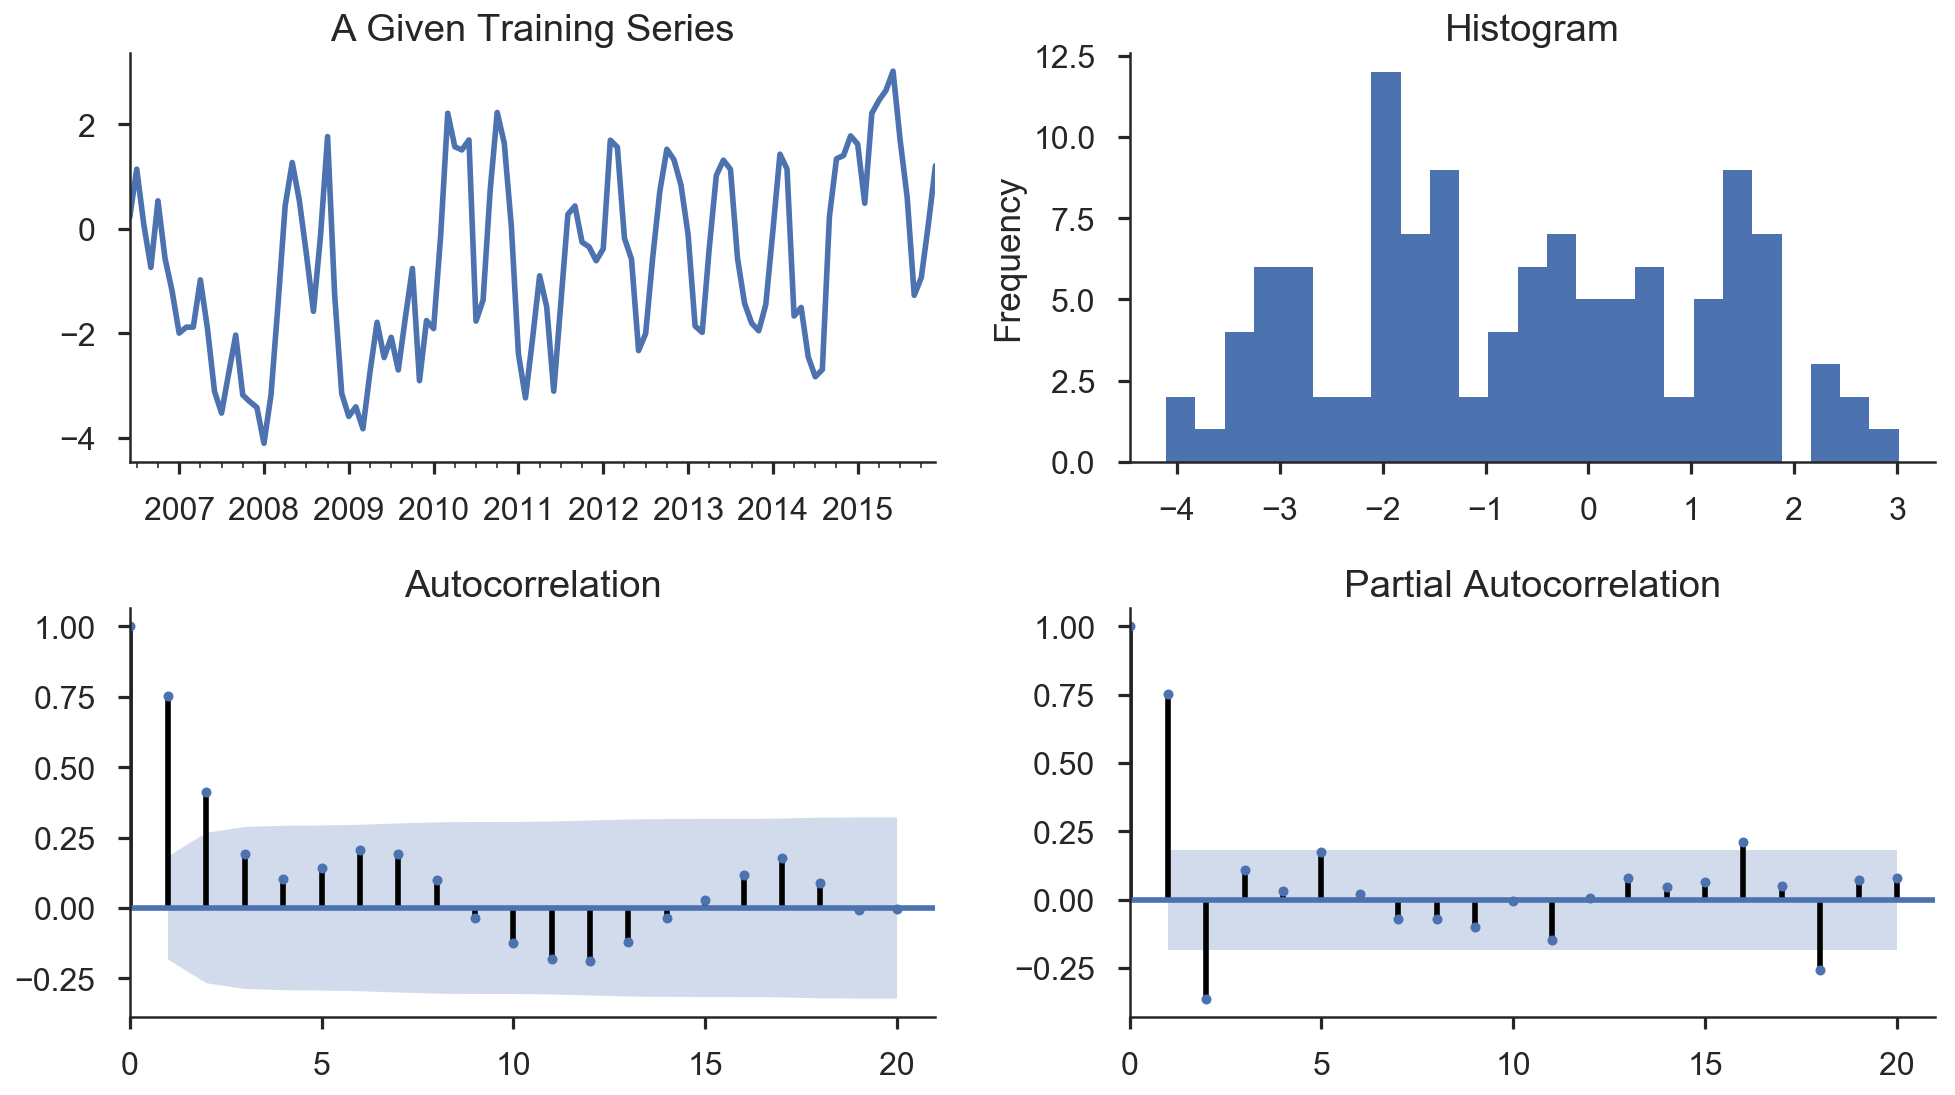

In [9]:
tsplot(ts_train, title='A Given Training Series', lags=20);

In [10]:
arima200 = sm.tsa.SARIMAX(ts_train, order=(2,0,0))
model_results = arima200.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  value   No. Observations:                  115
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -171.685
Date:                Tue, 07 Nov 2017   AIC                            349.370
Time:                        11:49:08   BIC                            357.605
Sample:                    06-01-2006   HQIC                           352.712
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0609      0.101     10.511      0.000       0.863       1.259
ar.L2         -0.3456      0.094     -3.664      0.000      -0.530      -0.161
sigma2         1.1471      0.153      7.516      0.000       0.848       1.446
===================================================================================
Ljung-Box (Q):                       70.87   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.00   Prob(JB):                         0.50
Heteroskedasticity (H):               0.76   Skew:                            -0.27
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Search over a few models using the visual clues above as a strating point

In [23]:
import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

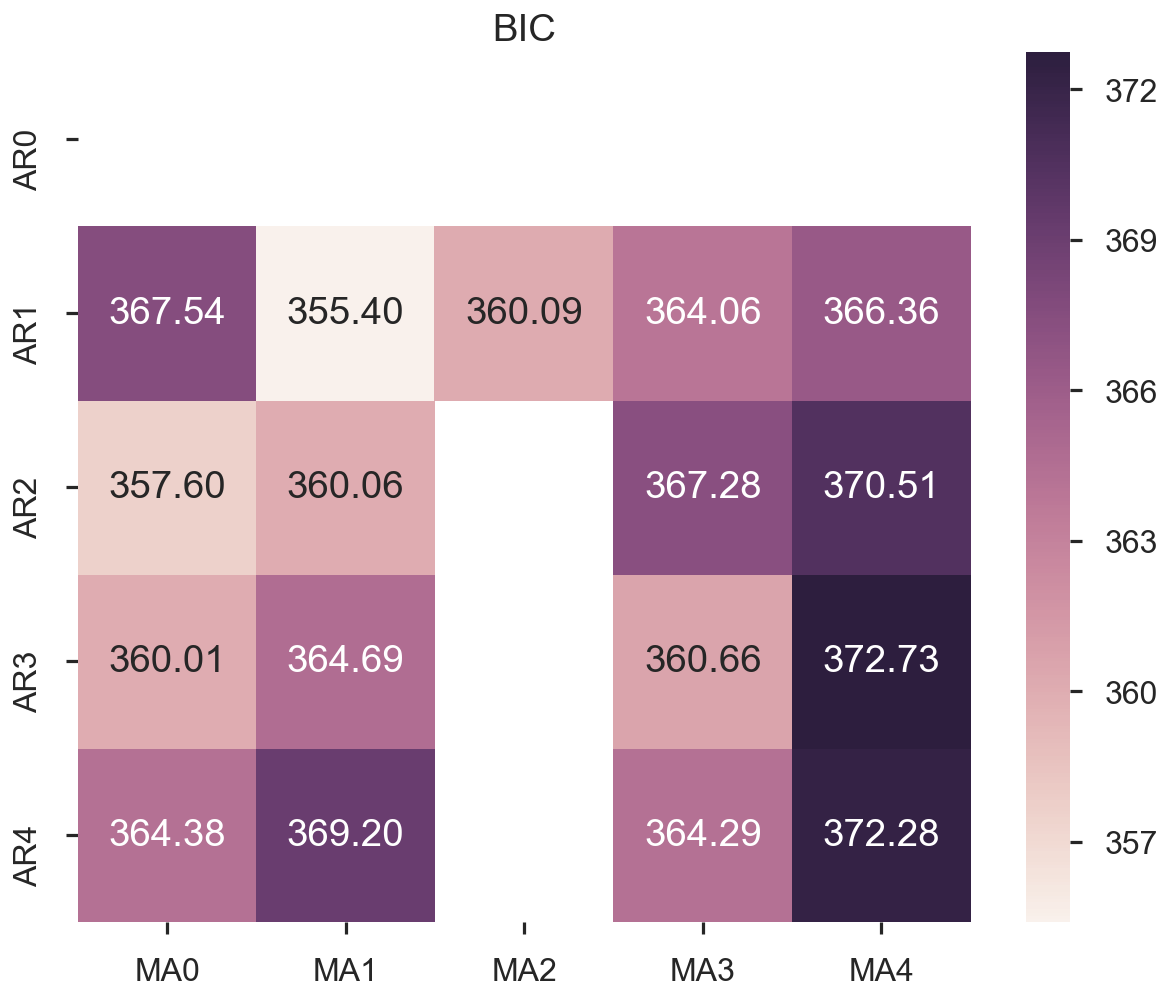

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(results_bic, 
                 mask = results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f')
ax.set_title('BIC')

#### Alternative model selection method, limited to only searching AR and MA parameters

In [22]:
train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 2)
BIC (1, 1)
